In [1]:
import os
import pickle
import json
import time
import pandas as pd 
import cv2

from glob import glob #파일들의 리스트를 뽑을 때 사용함
from tqdm import tqdm #내가 의도한 데로 돌아가고 있는 중인가, 진행상황 확인

import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
print(f"train images 수: {len(glob('./data/train/*')):,}")
print(f"test images 수: {len(glob('./data/test/*')):,}")

train images 수: 5,767
test images 수: 51,906


In [3]:
start_time = time.time()
tr_json_list = glob('./data/train/*/*.json') #파일명 리스트로 변환
# tr_json_list = ['./data' + x[1:] for x in tr_json_list]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.4311833381652832 seconds ---


In [7]:
for i, json_file in enumerate(tqdm(tr_json_list)):
    with open(json_file, 'r') as f:
        json_file = json.load(f)
    json_file_re = {
      '주목객체': json_file['annotations']['bbox'],
      '병해부위': json_file['annotations']['part'],
      '촬영부위': json_file['annotations']['area'], 
      '작물': json_file['annotations']['crop'],
      '질병명': json_file['annotations']['disease'],
      '생육단계': json_file['annotations']['grow'],
      '피해정도': json_file['annotations']['risk'],
      '이미지id': json_file['description']['image'],
      '촬영날짜': json_file['description']['date'],
      '촬영시간': json_file['description']['time'],
      'height': json_file['description']['height'],
      'width': json_file['description']['width'],
      '촬영지역': json_file['description']['region'],
      '데이터종류': json_file['description']['task']
      }
    #json_normalize는 이름만 봐도 그 역할을 짐작할 수 있다. normalize -> 뭔가 노멀하게 만든다는데 pandas에서 노멀하게 만드는건 뭘까? 바로 데이터프레임으로 만드는 것이다. 
    #즉, json_normalize는 json에서 데이터프레임을 쉽게 생성하도록 도움을 주는 메서드라고 할 수 있다.
    if i == 0:
        tr_json_df = pd.json_normalize(json_file_re)
    else:
        tr_json_df = tr_json_df.append(pd.json_normalize(json_file_re))
tr_json_df = tr_json_df.reset_index(drop=True)

100%|█████████████████████████████████████████████████████████████████████████████| 5767/5767 [00:20<00:00, 278.10it/s]


In [9]:
tr_json_df #json을 사용하기 -> 이런 방식을 통해 dataFrame으로 제작

주목객체  \
0     [{'x': 89.14301990327381, 'h': 237.86294022817...   
1     [{'x': 166.36469184027777, 'h': 315.9944816468...   
2     [{'x': 55.17857142857143, 'h': 271.60714285714...   
3     [{'x': 128.79953342013889, 'h': 263.3427579365...   
4     [{'x': 42.85714453125, 'h': 283.9285625, 'y': ...   
...                                                 ...   
5762  [{'x': 51.68989877852182, 'h': 370.31569320436...   
5763  [{'x': 121.90190625, 'h': 488.58658333333335, ...   
5764  [{'x': 213.33333333333334, 'h': 174.4761904761...   
5765  [{'x': 151.56689453125, 'h': 239.5797717524509...   
5766  [{'x': 113.83978174603175, 'h': 424.3880208333...   

                                                   병해부위  촬영부위  작물 질병명  생육단계  \
0     [{'x': 125.57248263888889, 'h': 78.85906498015...     3   3  b7    13   
1                                                    []     5   3  00    11   
2                                                    []     1   3  00    13   
3                                                    []     3   3  00    11   
4                                                    []     1   3  00    13   
...                                                 ...   ...  ..  ..   ...   
5762                                                 []     5   3  00    11   
5763                                                 []     3   1  00    11   
5764  [{'x': 215.77143270502646, 'h': 170.6666666666...     3   2  a5    12   
5765                                                 []     3   1  00    12   
5766  [{'x': 124.72152467757937, 'h': 404.2986421130...     3   5  b6    13   

      피해정도      이미지id      촬영날짜  촬영시간  height  width  촬영지역  데이터종류  
0        1  10027.jpg  20211126  0935     512    384     0      2  
1        0  10037.jpg  20210914  0925     512    384     0      0  
2        0  10043.jpg  20210624  1332     512    384     0      0  
3        0  10045.jpg  20210915  1616     512    384     0      0  
4        0  10063.jpg  20210624  1430     512    384     0      0  
...    ...        ...       ...   ...     ...    ...   ...    ...  
5762     0  67640.jpg  20210930  1234     512    384     0      0  
5763     0  67644.jpg  20210916  0952     512    682     0      0  
5764     2  67647.jpg  20211017  1249     512    682     0      1  
5765     0  67649.jpg  20211007  0956     512    384     0      0  
5766     1  67678.jpg  20211102  1141     512    384     0      2  

[5767 rows x 14 columns]

In [10]:
# crop
crop_dict = {1 : '딸기',
             2 : '토마토',
             3 : '파프리카',
             4 : '오이', 
             5 : '고추',
             6 : '시설포도'
            }    
# risk
risk_dict = {0 : '정상',
             1 : '초기',
             2 : '중기',
             3 : '말기'}

task_dict = {0 : '정상',
             1 : '병해',
             2 : '생리장해',
            }## 보호제 처리 반응 삭제 tr_json_df['데이터종류'].unique() 3없음
# disease
disease_dict = {'00' : '정상',
                'a1' : '딸기잿빛곰팡이병-1',
                'a2' : '딸기흰가루병-1',
                'a3' : '오이노균병-1',
                'a4' : '오이흰가루병-1',
                'a5' : '토마토흰가루병-1',
                'a6' : '토마토잿빛곰팡이병-1',
                'a7' : '고추탄저병-1',
                'a8' : '고추흰가루병-1',
                'a9' : '파프리카흰가루병-1',
                'a10' : '파프리카잘록병-1',
                'a11' : '시설포도탄저병-1',
                'a12' : '시설포도노균병-1',
                'b1' : '냉해피해-2',
                'b2' : '열과-2',
                'b3' : '칼슘결핍-2',
                'b4' : '일소피해-2',
                'b5' : '축과병-2',
                'b6' : '다량원소결핍 (N)-2',
                'b7' : '다량원소결핍 (P)-2',
                'b8' : '다량원소결핍 (K)-2',
                # 'c1' : '딸기잿빛곰팡이병반응-2',
                # 'c2' : '딸기흰가루병반응-2',
                # 'c3' : '오이노균병반응-2',
                # 'c4' : '오이흰가루병반응-2',
                # 'c5' : '토마토흰가루병반응-2',
                # 'c6' : '토마토잿빛곰팡이병반응-2',
                # 'c7' : '고추탄저병반응-2',
                # 'c8' : '고추흰가루병반응-2',
                # 'c9' : '파프리카흰가루병반응-2',
                # 'c10' : '파프리카잘록병반응-2',
                # 'c11' : '시설포도탄저병반응-2',
                # 'c12' : '시설포도노균병반응-2'
               }

area_dict = {1 : '열매',
             2 : '꽃',
             3 : '잎',
             4 : '가지',
             5 : '줄기',
             6 : '뿌리',
             7 : '해충'}

grow_dict = {11: '유모기',
             12: '생장기',
             13: '착화/과실기',
             21: '발아기',
             22: '개화기',
             23: '신초생장기',
             24: '과실성숙기',
             25: '수확기',
             26: '휴먼기'}


In [11]:
tr_json_df['label_code'] =  tr_json_df['작물'].astype(str) + '_'  + tr_json_df['질병명'] + '_' + tr_json_df['피해정도'].astype(str)
print("train data에 존재하는 class 수: {len(tr_json_df['label_code'].nunique())}")

tr_json_df['작물'] = tr_json_df['작물'].map(crop_dict) + '(' + tr_json_df['작물'].astype(str) + ')' # 
tr_json_df['질병명'] = tr_json_df['질병명'].map(disease_dict) + '(' + tr_json_df['질병명'].astype(str) + ')'
tr_json_df['피해정도'] = tr_json_df['피해정도'].map(risk_dict) + '(' + tr_json_df['피해정도'].astype(str) + ')'
tr_json_df['데이터종류'] = tr_json_df['데이터종류'].map(task_dict) + '(' + tr_json_df['데이터종류'].astype(str) + ')'
tr_json_df['촬영부위'] = tr_json_df['촬영부위'].map(area_dict) + '(' + tr_json_df['촬영부위'].astype(str) + ')'
tr_json_df['생육단계'] = tr_json_df['생육단계'].map(grow_dict) + '(' + tr_json_df['생육단계'].astype(str) + ')'

tr_json_df['label_name'] =  tr_json_df['작물'].astype(str) + '_'  + tr_json_df['질병명'] + '_' + tr_json_df['피해정도'].astype(str)

train data에 존재하는 class 수: {len(tr_json_df['label_code'].nunique())}


### map을 통해 데이터 변환하기
pd.DataFrame.map or pd.Series.map

map은 사전에 정의한 내용을 변수에 적용할 수 있는 편리함 기능입니다.
머신러닝 모델에 학습하기 전 입력데이터의 형태를 모두 숫자로 변환하기위해 많이 사용되는 함수입니다.
아래와 같이 문자열로 이루어진 범주형 자료가 있다고 가정합니다.

In [12]:
tr_json_df #2개 컬럼 증가 label_code, label_name
#pandas에 map란 함수 기억

주목객체  \
0     [{'x': 89.14301990327381, 'h': 237.86294022817...   
1     [{'x': 166.36469184027777, 'h': 315.9944816468...   
2     [{'x': 55.17857142857143, 'h': 271.60714285714...   
3     [{'x': 128.79953342013889, 'h': 263.3427579365...   
4     [{'x': 42.85714453125, 'h': 283.9285625, 'y': ...   
...                                                 ...   
5762  [{'x': 51.68989877852182, 'h': 370.31569320436...   
5763  [{'x': 121.90190625, 'h': 488.58658333333335, ...   
5764  [{'x': 213.33333333333334, 'h': 174.4761904761...   
5765  [{'x': 151.56689453125, 'h': 239.5797717524509...   
5766  [{'x': 113.83978174603175, 'h': 424.3880208333...   

                                                   병해부위   촬영부위       작물  \
0     [{'x': 125.57248263888889, 'h': 78.85906498015...   잎(3)  파프리카(3)   
1                                                    []  줄기(5)  파프리카(3)   
2                                                    []  열매(1)  파프리카(3)   
3                                                    []   잎(3)  파프리카(3)   
4                                                    []  열매(1)  파프리카(3)   
...                                                 ...    ...      ...   
5762                                                 []  줄기(5)  파프리카(3)   
5763                                                 []   잎(3)    딸기(1)   
5764  [{'x': 215.77143270502646, 'h': 170.6666666666...   잎(3)   토마토(2)   
5765                                                 []   잎(3)    딸기(1)   
5766  [{'x': 124.72152467757937, 'h': 404.2986421130...   잎(3)    고추(5)   

                   질병명        생육단계   피해정도      이미지id      촬영날짜  촬영시간  height  \
0     다량원소결핍 (P)-2(b7)  착화/과실기(13)  초기(1)  10027.jpg  20211126  0935     512   
1               정상(00)     유모기(11)  정상(0)  10037.jpg  20210914  0925     512   
2               정상(00)  착화/과실기(13)  정상(0)  10043.jpg  20210624  1332     512   
3               정상(00)     유모기(11)  정상(0)  10045.jpg  20210915  1616     512   
4               정상(00)  착화/과실기(13)  정상(0)  10063.jpg  20210624  1430     512   
...                ...         ...    ...        ...       ...   ...     ...   
5762            정상(00)     유모기(11)  정상(0)  67640.jpg  20210930  1234     512   
5763            정상(00)     유모기(11)  정상(0)  67644.jpg  20210916  0952     512   
5764     토마토흰가루병-1(a5)     생장기(12)  중기(2)  67647.jpg  20211017  1249     512   
5765            정상(00)     생장기(12)  정상(0)  67649.jpg  20211007  0956     512   
5766  다량원소결핍 (N)-2(b6)  착화/과실기(13)  초기(1)  67678.jpg  20211102  1141     512   

      width  촬영지역    데이터종류 label_code                      label_name  
0       384     0  생리장해(2)     3_b7_1  파프리카(3)_다량원소결핍 (P)-2(b7)_초기(1)  
1       384     0    정상(0)     3_00_0            파프리카(3)_정상(00)_정상(0)  
2       384     0    정상(0)     3_00_0            파프리카(3)_정상(00)_정상(0)  
3       384     0    정상(0)     3_00_0            파프리카(3)_정상(00)_정상(0)  
4       384     0    정상(0)     3_00_0            파프리카(3)_정상(00)_정상(0)  
...     ...   ...      ...        ...                             ...  
5762    384     0    정상(0)     3_00_0            파프리카(3)_정상(00)_정상(0)  
5763    682     0    정상(0)     1_00_0              딸기(1)_정상(00)_정상(0)  
5764    682     0    병해(1)     2_a5_2      토마토(2)_토마토흰가루병-1(a5)_중기(2)  
5765    384     0    정상(0)     1_00_0              딸기(1)_정상(00)_정상(0)  
5766    384     0  생리장해(2)     5_b6_1    고추(5)_다량원소결핍 (N)-2(b6)_초기(1)  

[5767 rows x 16 columns]

In [13]:
import platform
from matplotlib import font_manager, rc
import warnings
warnings.filterwarnings("ignore")

if platform.system() == 'Windows':
# 윈도우인 경우 맑은 고딕 폰트 이용
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

### # 1. Class 분포
각 클래스별 분포를 살펴봅니다.

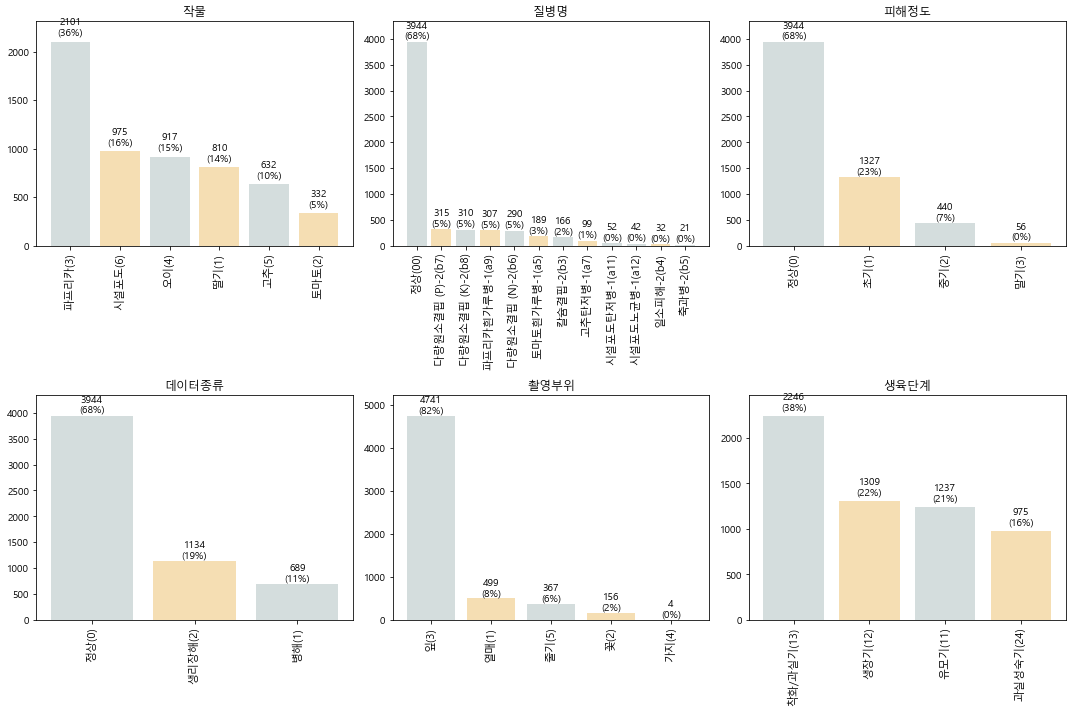

In [14]:
f, axs = plt.subplots(2,3,figsize=(15,10))
axs = axs.flatten()
for i, col in enumerate(['작물', '질병명', '피해정도', '데이터종류', '촬영부위', '생육단계']):
    object_cnt = tr_json_df[col].value_counts().sort_values(ascending=False)
    axs[i].bar(object_cnt.index, object_cnt.values, color=['#d4dddd' if i%2==0 else '#F5DEB3' for i in range(9)])
    for x,y,z in zip(object_cnt.index, object_cnt.values,object_cnt.values/object_cnt.sum()*100):                                       # <--
        axs[i].annotate('%d\n(%d%%)' %(int(y),z), xy=(x,y+70), textcoords='data', ha = 'center') 
    axs[i].axis(ymin=0,ymax=int(max(object_cnt)*1.1))
    axs[i].set_xticklabels(object_cnt.index, rotation = 90,fontsize = 11)
    axs[i].set_title(col)
f.tight_layout()
plt.show()

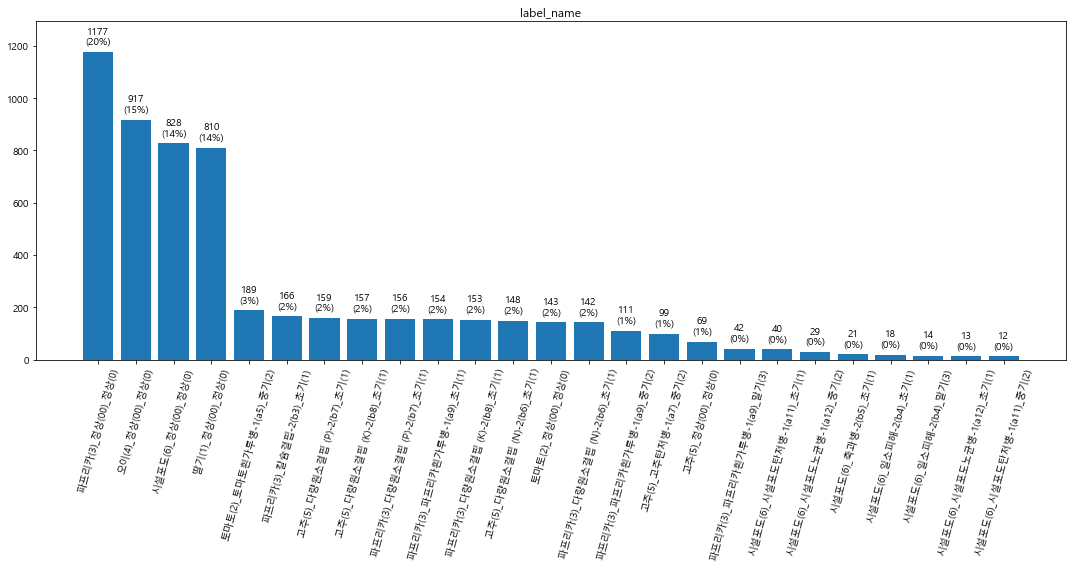

In [15]:
f, axs = plt.subplots(1,1,figsize=(15,8))
# axs = axs.flatten()
for i, col in enumerate(['label_name']):
    object_cnt = tr_json_df[col].value_counts().sort_values(ascending=False)
    axs.bar(object_cnt.index, object_cnt.values)
    for x,y,z in zip(object_cnt.index, object_cnt.values,object_cnt.values/object_cnt.sum()*100):                                       # <--
        axs.annotate('%d\n(%d%%)' %(int(y),z), xy=(x,y+30), textcoords='data', ha = 'center') 
    axs.axis(ymin=0,ymax=int(max(object_cnt)*1.1))
    axs.set_xticklabels(object_cnt.index, rotation = 75)
    axs.set_title(col)
f.tight_layout()
plt.show()

- 각 클래스별로 불균형 존재
- 예측해야하는 것 작물, 질병명, 피해정도 예측\
- 질병명 클래스도 많고 너무 적은것들 존재
- 피해정도도 말기인 데이터 거의 없다.

In [20]:
tmp = tr_json_df.groupby('작물')['질병명'].value_counts().rename('cnt').reset_index()
tmp2 = tr_json_df.groupby(['질병명'])['피해정도'].value_counts().rename('cnt').reset_index()

In [21]:
i = 0
tmp_dict = {}
for c_list in [tmp['작물'].unique(), tmp['질병명'].unique(), tmp2['피해정도'].unique()]:
    for x in c_list:
        tmp_dict[x] = i
        i+=1 

In [22]:
tmp_dict

{'고추(5)': 0,
 '딸기(1)': 1,
 '시설포도(6)': 2,
 '오이(4)': 3,
 '토마토(2)': 4,
 '파프리카(3)': 5,
 '다량원소결핍 (P)-2(b7)': 6,
 '다량원소결핍 (K)-2(b8)': 7,
 '다량원소결핍 (N)-2(b6)': 8,
 '고추탄저병-1(a7)': 9,
 '정상(00)': 10,
 '시설포도탄저병-1(a11)': 11,
 '시설포도노균병-1(a12)': 12,
 '일소피해-2(b4)': 13,
 '축과병-2(b5)': 14,
 '토마토흰가루병-1(a5)': 15,
 '파프리카흰가루병-1(a9)': 16,
 '칼슘결핍-2(b3)': 17,
 '중기(2)': 18,
 '초기(1)': 19,
 '말기(3)': 20,
 '정상(0)': 21}

In [23]:
import plotly.io as pio
pio.renderers.default = "notebook_connected" 

In [24]:
NODES = dict(
label = list(tmp_dict.keys()),
)
LINKS = dict(   source = list(tmp['작물'].map(tmp_dict).values) + list(tmp2['질병명'].map(tmp_dict).values), 
target = list(tmp['질병명'].map(tmp_dict).values) + list(tmp2['피해정도'].map(tmp_dict).values),
value =  list(tmp['cnt'].values) + list(tmp2['cnt'].values), 
)
data = go.Sankey(node = NODES, link = LINKS)
fig = go.Figure(data)
fig.show()

**알게된것**  

작물과 질병  
- 딸기, 오이 정상만 존재
- 토마토는 흰가루병 아니면 정상 둘 중 하나
- 시설포도 노균병, 일소피해, 축과병 포도만 걸림
- 다량원소결핍 N, P, K는 파프리카와 고추만 걸렷는데 토마토, 오이, 딸기에도 발생할 수 있다.
- 칼슘결핍은 파프리카에만 존재, 고추와 토마토에도 발생 가능
- 축과병(시설포도), 일소피해(시설포도), 냉해피해(딸기, 오이), 열과(토마토) << 이와 같은 병해 발생하지 않았다. 그렇다면 테스트에서도 이와 같은 질병은 예측 못하지 않을까 생각됨
- 노균병 포도에만 있는데 오이에도 발병 할 수 있다.

  
질병과 피해정도
- 결핍은 피해정도가 초기만 존재한다.
- 축과병(시설포도)도 초기만
- 토마토 흰가루병이랑 초기만 존재하는데 파프리카 흰가루병은 초기, 중기, 말기 다 존재
- 고추 탄저병 중기만 존재하는데 시설포도 탄저병은 초기 중기 존재
- 일소피해 말기랑 초기만 존재

**궁금한것**
- 흰가루병은 토마토와 파프리카에만 존재하는데 둘이 다른 양상을 보일까?
- 탄저병은 포도와 고추에만 보이는데 또 비슷할까?
- 즉 어떠한 질병이 두개 이상의 작물에 발생했다면 그게 다른 양상을 띄는지 확인해보기
- 파프리카 흰가루병은 초기, 중기, 말기 다 있으므로 이를 이용해 피해정도가 어떤 양상이 다른지 확인해보기
- 각 질병의 원인도 알면 좋을듯 하다.

In [25]:
tr_json_df['month'] = tr_json_df['촬영날짜'].apply(lambda x: x[4:6])

In [26]:
tmp = tr_json_df.groupby('작물')['month'].value_counts().rename('cnt').reset_index()
tmp2 = tr_json_df.groupby(['month'])['질병명'].value_counts().rename('cnt').reset_index()

i = 0
tmp_dict = {}
for c_list in [tmp['작물'].unique(), tmp['month'].unique(), tmp2['질병명'].unique()]:
    for x in c_list:
        tmp_dict[x] = i
        i+=1 
        
NODES = dict(
label = list(tmp_dict.keys()),
)
LINKS = dict(   source = list(tmp['작물'].map(tmp_dict).values) + list(tmp2['month'].map(tmp_dict).values), 
target = list(tmp['month'].map(tmp_dict).values) + list(tmp2['질병명'].map(tmp_dict).values),
value =  list(tmp['cnt'].values) + list(tmp2['cnt'].values), 
) 
data = go.Sankey(node = NODES, link = LINKS)
fig = go.Figure(data)
fig.show()
fig.write_html('example3.html')

### 주목개체

In [27]:
tr_json_df['center_x'] = tr_json_df['주목객체'].apply(lambda x: int(x[0]['x']+x[0]['w']/2))
tr_json_df['center_y'] = tr_json_df['주목객체'].apply(lambda x: int(x[0]['y']+x[0]['h']/2))

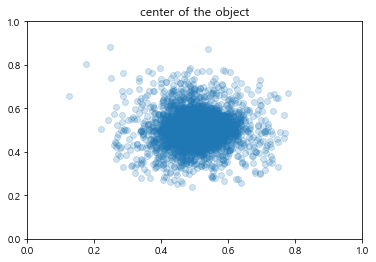

In [28]:
plt.scatter(tr_json_df['center_x']/tr_json_df['width'], 
            tr_json_df['center_y']/tr_json_df['height'],
           alpha = 0.2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('center of the object')
plt.show()

In [33]:
tr_json_df

주목객체  \
0     [{'x': 89.14301990327381, 'h': 237.86294022817...   
1     [{'x': 166.36469184027777, 'h': 315.9944816468...   
2     [{'x': 55.17857142857143, 'h': 271.60714285714...   
3     [{'x': 128.79953342013889, 'h': 263.3427579365...   
4     [{'x': 42.85714453125, 'h': 283.9285625, 'y': ...   
...                                                 ...   
5762  [{'x': 51.68989877852182, 'h': 370.31569320436...   
5763  [{'x': 121.90190625, 'h': 488.58658333333335, ...   
5764  [{'x': 213.33333333333334, 'h': 174.4761904761...   
5765  [{'x': 151.56689453125, 'h': 239.5797717524509...   
5766  [{'x': 113.83978174603175, 'h': 424.3880208333...   

                                                   병해부위   촬영부위       작물  \
0     [{'x': 125.57248263888889, 'h': 78.85906498015...   잎(3)  파프리카(3)   
1                                                    []  줄기(5)  파프리카(3)   
2                                                    []  열매(1)  파프리카(3)   
3                                                    []   잎(3)  파프리카(3)   
4                                                    []  열매(1)  파프리카(3)   
...                                                 ...    ...      ...   
5762                                                 []  줄기(5)  파프리카(3)   
5763                                                 []   잎(3)    딸기(1)   
5764  [{'x': 215.77143270502646, 'h': 170.6666666666...   잎(3)   토마토(2)   
5765                                                 []   잎(3)    딸기(1)   
5766  [{'x': 124.72152467757937, 'h': 404.2986421130...   잎(3)    고추(5)   

                   질병명        생육단계   피해정도      이미지id      촬영날짜  촬영시간  height  \
0     다량원소결핍 (P)-2(b7)  착화/과실기(13)  초기(1)  10027.jpg  20211126  0935     512   
1               정상(00)     유모기(11)  정상(0)  10037.jpg  20210914  0925     512   
2               정상(00)  착화/과실기(13)  정상(0)  10043.jpg  20210624  1332     512   
3               정상(00)     유모기(11)  정상(0)  10045.jpg  20210915  1616     512   
4               정상(00)  착화/과실기(13)  정상(0)  10063.jpg  20210624  1430     512   
...                ...         ...    ...        ...       ...   ...     ...   
5762            정상(00)     유모기(11)  정상(0)  67640.jpg  20210930  1234     512   
5763            정상(00)     유모기(11)  정상(0)  67644.jpg  20210916  0952     512   
5764     토마토흰가루병-1(a5)     생장기(12)  중기(2)  67647.jpg  20211017  1249     512   
5765            정상(00)     생장기(12)  정상(0)  67649.jpg  20211007  0956     512   
5766  다량원소결핍 (N)-2(b6)  착화/과실기(13)  초기(1)  67678.jpg  20211102  1141     512   

      width  촬영지역    데이터종류 label_code                      label_name month  \
0       384     0  생리장해(2)     3_b7_1  파프리카(3)_다량원소결핍 (P)-2(b7)_초기(1)    11   
1       384     0    정상(0)     3_00_0            파프리카(3)_정상(00)_정상(0)    09   
2       384     0    정상(0)     3_00_0            파프리카(3)_정상(00)_정상(0)    06   
3       384     0    정상(0)     3_00_0            파프리카(3)_정상(00)_정상(0)    09   
4       384     0    정상(0)     3_00_0            파프리카(3)_정상(00)_정상(0)    06   
...     ...   ...      ...        ...                             ...   ...   
5762    384     0    정상(0)     3_00_0            파프리카(3)_정상(00)_정상(0)    09   
5763    682     0    정상(0)     1_00_0              딸기(1)_정상(00)_정상(0)    09   
5764    682     0    병해(1)     2_a5_2      토마토(2)_토마토흰가루병-1(a5)_중기(2)    10   
5765    384     0    정상(0)     1_00_0              딸기(1)_정상(00)_정상(0)    10   
5766    384     0  생리장해(2)     5_b6_1    고추(5)_다량원소결핍 (N)-2(b6)_초기(1)    11   

      center_x  center_y  
0          171       280  
1          190       160  
2          191       252  
3          214       319  
4          185       288  
...        ...       ...  
5762       131       185  
5763       401       258  
5764       374       303  
5765       261       155  
5766       206       253  

[5767 rows x 19 columns]

# 3.이미지 비교 

## 작물별 잎의 모양 비교

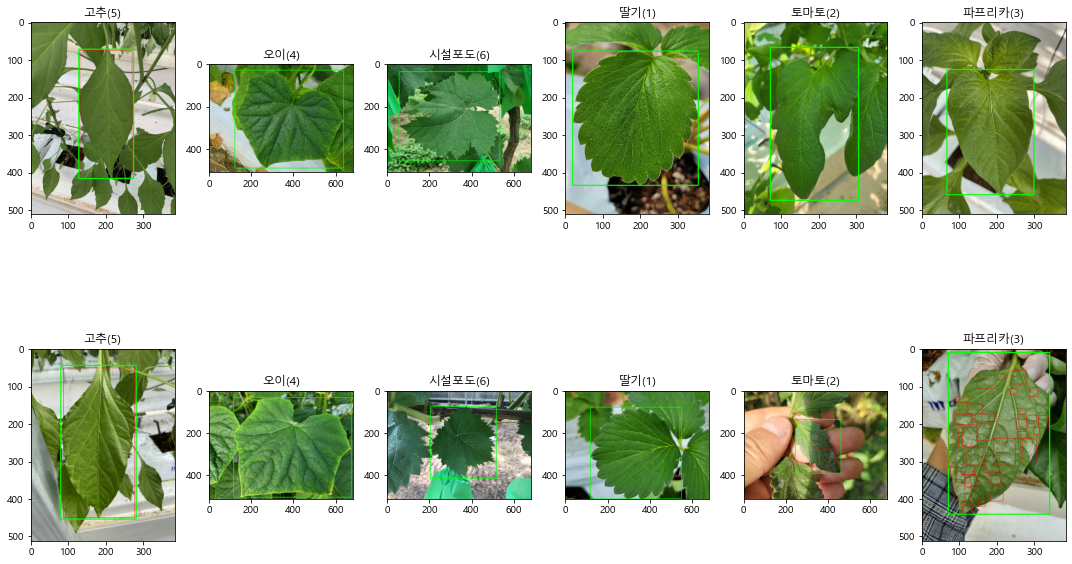

In [32]:
fig, ax = plt.subplots(2, 6, figsize=(15, 10))
ax = ax.flatten()

for i, name in enumerate(['고추(5)', '오이(4)', '시설포도(6)', '딸기(1)', '토마토(2)', '파프리카(3)'] * 2):
    tmp = tr_json_df.loc[(tr_json_df['촬영부위'] == '잎(3)')&(tr_json_df['작물']==name)].sample(1)
    img = cv2.imread("./data/train/"+tmp['이미지id'].iloc[0].split('.')[0]+'/'+tmp['이미지id'].iloc[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    points = tmp['주목객체'].iloc[0][0]
    part_points = tmp['병해부위'].iloc[0]
    #주목객체 부위의 x,y좌표를 가져와 cv2.rectangle을 사용한다.
    # 이미지, start_point, end_point, color, thickness로 사용한다
    cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])), # start_point
    (int((points['x']+points['w'])), int((points['y']+points['h']))),# end_point
    (0, 255, 0)#color,
    2 ) #thinckness
    
    for part_point in part_points:
        point = part_point
        cv2.rectangle(
            img,
            (int(point['x']), int(point['y'])),
            (int((point['x']+point['w'])), int((point['y']+point['h']))),
            (255, 0, 0),
            1
        )
    ax[i].imshow(img)
    ax[i].set_title(name)
plt.tight_layout()
plt.show()

## 질병명 비교 

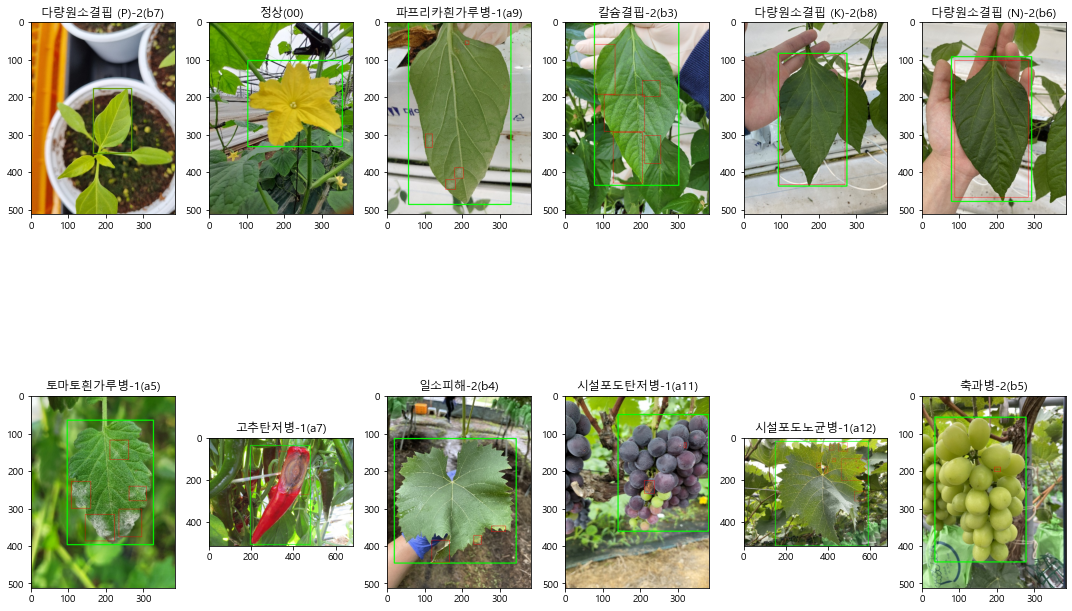

In [41]:
# fig, ax = plt.subplots(2, 6, figsize=(30, 24)) 이렇게 하면 쪼개서 그런가 이상함
fig, ax = plt.subplots(2, 6, figsize=(15, 12))
ax = ax.flatten()

for i, name in enumerate(tr_json_df['질병명'].unique()):
    tmp = tr_json_df.loc[tr_json_df['질병명']==name].sample(1)
    img = cv2.imread("./data/train/"+tmp['이미지id'].iloc[0].split('.')[0]+'/'+tmp['이미지id'].iloc[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    points = tmp['주목객체'].iloc[0][0]
    part_points = tmp['병해부위'].iloc[0]
    cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2) 

    for part_point in part_points:
        point = part_point
        cv2.rectangle(
            img,
            (int(point['x']), int(point['y'])),
            (int((point['x']+point['w'])), int((point['y']+point['h']))),
            (255, 0, 0),
            1
        )

    ax[i].imshow(img)
    ax[i].set_title(name)
plt.tight_layout()
plt.show()

결핍은 전공자가 아니면 육안 구분 x , 병을 봐도 이해가 안감 (도메인 공부)

## 고추, 시절포도 탄저병 비교

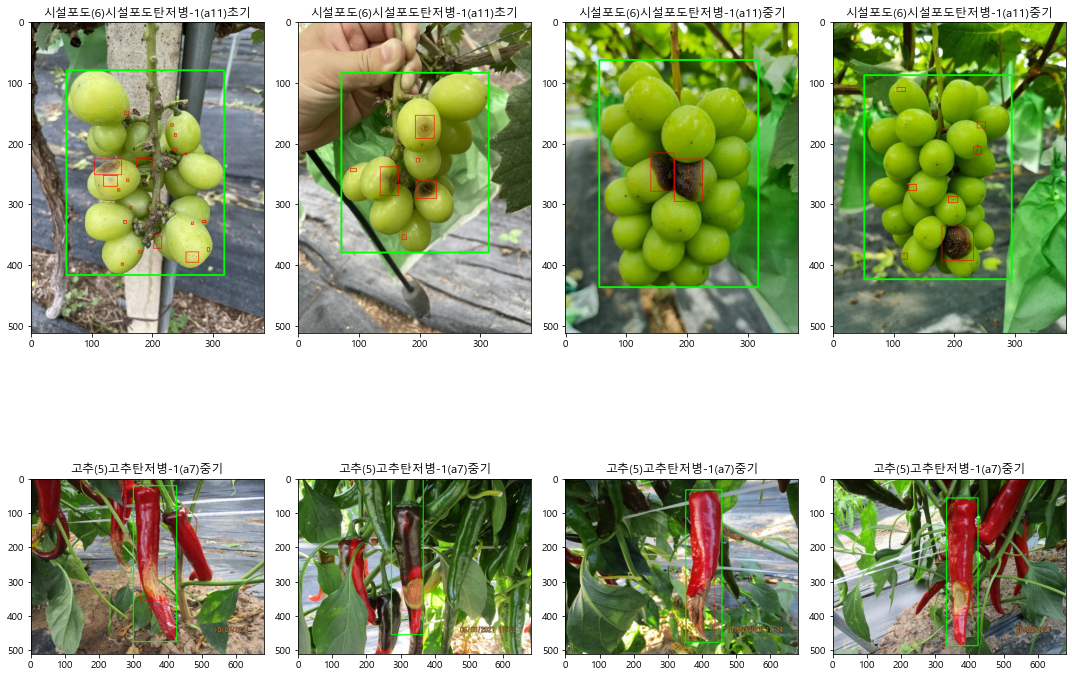

In [42]:
fig, ax = plt.subplots(2, 4, figsize=(15, 12))
ax = ax.flatten()

for i, name in enumerate(['시설포도탄저병-1(a11)']*4+['고추탄저병-1(a7)']*4):
    if i < 2:
        tmp = tr_json_df.loc[(tr_json_df['작물']=='시설포도(6)') &(tr_json_df['질병명'] == name)&(tr_json_df['피해정도']=='초기(1)')].sample(1)
    elif i < 4:
        tmp = tr_json_df.loc[(tr_json_df['작물']=='시설포도(6)') &(tr_json_df['질병명'] == name)&(tr_json_df['피해정도']=='중기(2)')].sample(1)
    else:
        tmp = tr_json_df.loc[(tr_json_df['작물']=='고추(5)') &(tr_json_df['질병명'] == name)].sample(1)
    img = cv2.imread("./data/train/"+tmp['이미지id'].iloc[0].split('.')[0]+'/'+tmp['이미지id'].iloc[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    points = tmp['주목객체'].iloc[0][0]
    part_points = tmp['병해부위'].iloc[0]
    cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2) 

    for part_point in part_points:
        point = part_point
        cv2.rectangle(
            img,

            (int(point['x']), int(point['y'])),
            (int((point['x']+point['w'])), int((point['y']+point['h']))),
            (255, 0, 0),
            1
        )

    ax[i].imshow(img)
    if i < 2:
        ax[i].set_title(tmp['작물'].iloc[0]+name+'초기')
    else:
        ax[i].set_title(tmp['작물'].iloc[0]+name+'중기')
plt.tight_layout()
plt.show()

## 일소피해, 축과병, 시절포도노균병

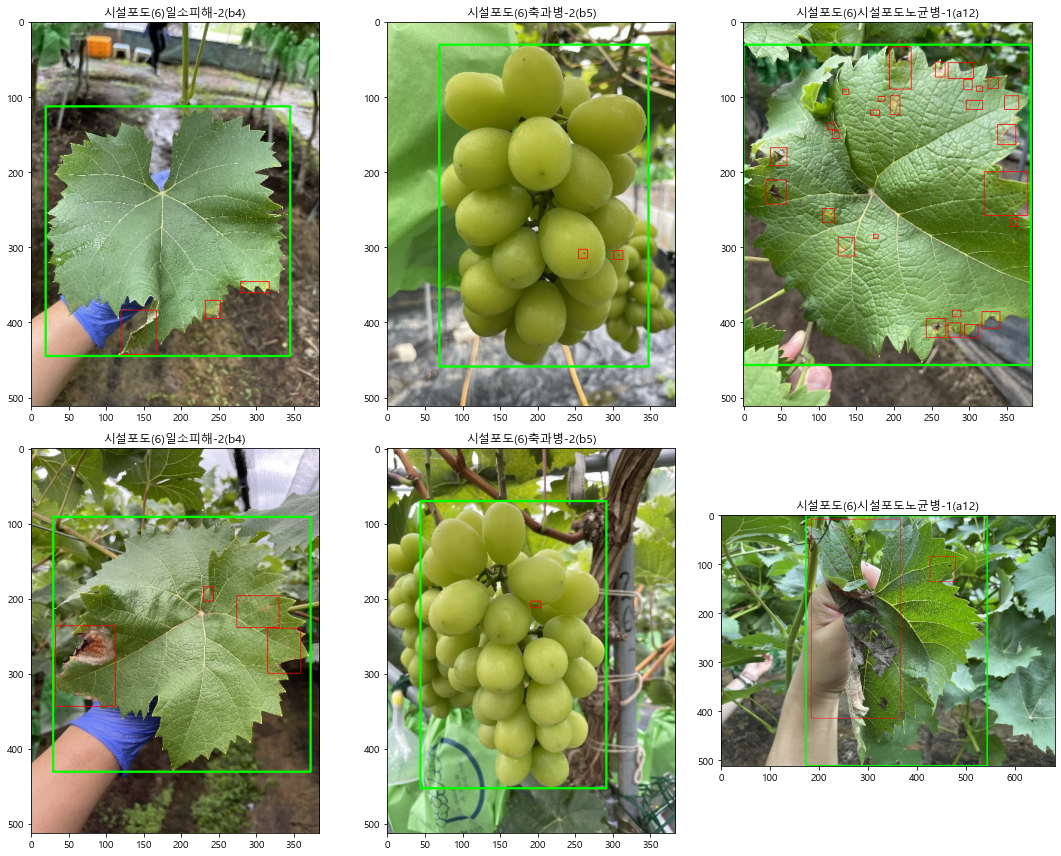

In [43]:
fig, ax = plt.subplots(2, 3, figsize=(15, 12))
ax = ax.flatten()

for i, name in enumerate(['일소피해-2(b4)', '축과병-2(b5)', '시설포도노균병-1(a12)']*2):
    tmp = tr_json_df.loc[(tr_json_df['질병명'] == name)].sample(1)
    img = cv2.imread("./data/train/"+tmp['이미지id'].iloc[0].split('.')[0]+'/'+tmp['이미지id'].iloc[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    points = tmp['주목객체'].iloc[0][0]
    part_points = tmp['병해부위'].iloc[0]
    cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2) 

    for part_point in part_points:
        point = part_point
        cv2.rectangle(
            img,

            (int(point['x']), int(point['y'])),
            (int((point['x']+point['w'])), int((point['y']+point['h']))),
            (255, 0, 0),
            1
        )

    ax[i].imshow(img)
    ax[i].set_title(tmp['작물'].iloc[0]+name)
plt.tight_layout()
plt.show()